## Imports

In [1]:
# modules: --------------------------------------------------------------------
import numpy as np
import pandas as pd
from scipy.stats import t, bootstrap
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import statsmodels.api as sm
import statsmodels.formula.api as smf
from os.path import exists
from IPython.display import display, Markdown
# 79: -------------------------------------------------------------------------

## Figure Settings

In [2]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

## Question 0 - R-Squared Warmup

Load "ToothGrowth" data from the R datasets packag by statsmodels.

In [3]:
# tooth growth data
file = 'tooth_growth.feather'
if exists(file):
    tg_data = pd.read_feather(file)
else: 
    tooth_growth = sm.datasets.get_rdataset('ToothGrowth')
    #print(tooth_growth.__doc__)
    tg_data = tooth_growth.data
    tg_data.to_feather(file)
#tg_data

In [4]:
tg_data['log_len'] = tg_data[['len']].transform(np.log)
tg_data['OJ'] = pd.get_dummies(tg_data['supp'])['OJ']
tg_data['dose_cat'] = pd.Categorical(tg_data['dose'])

mod = sm.OLS.from_formula('log_len ~ OJ*dose_cat', data=tg_data)
res = mod.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:               OLS              Adj. R-squared:     0.775   
Dependent Variable:  log_len          AIC:                3.4775  
Date:                2021-11-07 16:08 BIC:                16.0436 
No. Observations:    60               Log-Likelihood:     4.2612  
Df Model:            5                F-statistic:        41.69   
Df Residuals:        54               Prob (F-statistic): 2.34e-17
R-squared:           0.794            Scale:              0.056441
------------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept           2.0208   0.0751 26.8989 0.0000  1.8702  2.1715
dose_cat[T.1.0]     0.7893   0.1062  7.4294 0.0000  0.5763  1.0024
dose_cat[T.2.0]     1.2273   0.1062 11.5513 0.0000  1.0143  1.4403
OJ                  0.5118   0.1062  4.8171 0.0000  0.2988  0.7248
OJ:dose_cat[T.1.0] -0.2148   0.1503 -1.4297 0.1586 -0.5161  0.0864
OJ:dose_cat[T.2.0] -0.5041   0.1503 -3.3551 0.0015 -0.8054 -0.2029
------------------------------------------------------------------
Omnibus:              0.136         Durbin-Watson:           1.862
Prob(Omnibus):        0.934         Jarque-Bera (JB):        0.039
Skew:                 -0.058        Prob(JB):                0.981
Kurtosis:             2.953         Condition No.:           10   
==================================================================

"""

The R-Squared is defined by 
$$
R^2=1-\frac{\sum^{n}_{i=1}(y_i-\tilde{y}_i)^2}{\sum^{n}_{i=1}(y_i-E(y))^2}
$$
where $\tilde{y}_i$ is the predicted value of the linear model and $y_i$ is the actual value. And The adjust R-Squared is defined by
$$
R_{adj}^2=1-\frac{(1-R^2)(n-1)}{n-p-1}
$$
where $n$ is the number of samples and $p$ is the number of parameters

In [5]:
# evaluate the R^2 and adjust R^2

X, params = mod.exog, res.params
yt = mod.predict(params, X)
y = tg_data['log_len'].to_numpy()

n = X.shape[0]
p = X.shape[1]-1

R2 = 1-(sum((y-yt)**2))/(sum((y-y.mean())**2))
R2adj = 1-(1-R2)*(n-1)/(n-p-1)

display(Markdown('The $R^2$ is ${}$ and the adjust $R^2$ is ${}$. '
                 'This result is consistent with the result given in the result object. '.format(R2, R2adj)))

The $R^2$ is $0.7942457970936072$ and the adjust $R^2$ is $0.7751944820096819$. This result is consistent with the result given in the result object. 

## Question 1 - NHANES Dentition 

### a.

In [6]:
# load data

demo_file = 'demo.feather'
ohx_file = 'ohx.feather'

demo = pd.read_feather(demo_file)
ohx = pd.read_feather(ohx_file)

In [7]:
# select age and tc_01 to experiment 

tc01_data = pd.merge(demo, ohx[['id', 'tc_01']], on='id', how='left')
tc01_data['permanent_tooth_present'] = pd.get_dummies(tc01_data['tc_01'])['Permanent tooth present']
#tc01_data

For the sake of simplicity, we directly set degree=3. At this time, BSpline will provide 3 bases. And we consider two different models, one with interaction terms and the other without. We use AIC to compare the models.

In [8]:
# no knots needed for simplicity
bs = sm.gam.BSplines(x=tc01_data['age'],df=4,degree=3,
                     include_intercept=False)

age_basis = pd.DataFrame(bs.basis,columns=['p0','p1','p2'])

In [9]:
tc01_f_data = age_basis.copy()
tc01_f_data['age'] = tc01_data['age']
tc01_f_data['permanent_tooth_present'] = tc01_data['permanent_tooth_present']

f1 = 'permanent_tooth_present~p0+p1+p2'
mod1 = smf.logit(f1, data=tc01_f_data)
res1 = mod1.fit()
print('model:{}\n AIC: {}\n'.format(f1,res1.aic))

f2 = 'permanent_tooth_present~p0+p1+p2+p0:p1+p1:p2+p0:p2'
mod2 = smf.logit(f2, data=tc01_f_data)
res2 = mod2.fit()
print('model: {}\nAIC: {}\n'.format(f2,res2.aic))


if res1.aic < res2.aic:
    fbest = f1
else:
    fbest = f2
print('choose model:'+fbest)

Optimization terminated successfully.
         Current function value: 0.320651
         Iterations 9
model:permanent_tooth_present~p0+p1+p2
 AIC: 25118.848595166593

Optimization terminated successfully.
         Current function value: 0.310987
         Iterations 21
model: permanent_tooth_present~p0+p1+p2+p0:p1+p1:p2+p0:p2
AIC: 24367.975711368887

choose model:permanent_tooth_present~p0+p1+p2+p0:p1+p1:p2+p0:p2


### b.

In [10]:
tc_cols = ['tc_' + str(i).zfill(2) for i in range(1, 33)]

tc_data =  pd.merge(demo[['id','age']], ohx[['id']+tc_cols], on='id', how='left')

tc_f_data = age_basis.copy()
for tc in tc_cols:
    tc_f_data['permanent_tooth_present'] = pd.get_dummies(tc_data[tc])['Permanent tooth present']
    mod = smf.logit(fbest, data=tc_f_data)
    res = mod.fit(disp=False)
    tc_data[tc] = mod.predict(res.params)

# show the results
tc_data

,id,age,tc_01,tc_02,tc_03,tc_04,tc_05,tc_06,tc_07,tc_08,...,tc_23,tc_24,tc_25,tc_26,tc_27,tc_28,tc_29,tc_30,tc_31,tc_32
0,62161,22,3.229809e-01,9.351522e-01,0.914933,9.361748e-01,0.892118,9.395551e-01,0.929264,0.930816,...,0.931222,0.924453,0.924089,0.929694,0.944402,0.907957,9.359669e-01,0.896276,9.284868e-01,3.577798e-01
1,62162,3,3.106626e-16,5.338789e-10,0.011419,7.475144e-08,0.000005,9.343724e-08,0.000316,0.002754,...,0.002491,0.019403,0.019423,0.002590,0.000001,0.000002,9.663100e-08,0.016065,4.166485e-09,2.687258e-14
2,62163,14,1.119033e-02,8.513031e-01,0.967836,9.016976e-01,0.896271,9.042967e-01,0.961112,0.969917,...,0.966847,0.970637,0.970237,0.966381,0.936867,0.909914,9.029095e-01,0.965878,8.899472e-01,2.458459e-02
3,62164,44,2.474940e-01,7.371760e-01,0.757714,7.618797e-01,0.749189,8.442366e-01,0.832052,0.836678,...,0.883573,0.881835,0.881586,0.882522,0.881185,0.824038,8.075360e-01,0.683935,7.098729e-01,2.913295e-01
4,62165,14,1.119033e-02,8.513031e-01,0.967836,9.016976e-01,0.896271,9.042967e-01,0.961112,0.969917,...,0.966847,0.970637,0.970237,0.966381,0.936867,0.909914,9.029095e-01,0.965878,8.899472e-01,2.458459e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39151,102952,70,1.147551e-01,4.008353e-01,0.416320,4.654147e-01,0.471861,5.786048e-01,0.539941,0.546834,...,0.663962,0.643938,0.642556,0.663223,0.699967,0.623737,5.261211e-01,0.357734,3.833813e-01,1.511217e-01
39152,102953,42,2.490792e-01,7.417545e-01,0.766066,7.671731e-01,0.749861,8.439236e-01,0.832970,0.838519,...,0.881837,0.880929,0.880771,0.880696,0.877398,0.819491,8.086489e-01,0.695050,7.137736e-01,2.897379e-01
39153,102954,41,2.500214e-01,7.436729e-01,0.768730,7.693596e-01,0.749170,8.431455e-01,0.832305,0.838253,...,0.879953,0.879308,0.879193,0.878747,0.874894,0.816206,8.086414e-01,0.698911,7.151098e-01,2.889210e-01
39154,102955,14,1.119033e-02,8.513031e-01,0.967836,9.016976e-01,0.896271,9.042967e-01,0.961112,0.969917,...,0.966847,0.970637,0.970237,0.966381,0.936867,0.909914,9.029095e-01,0.965878,8.899472e-01,2.458459e-02


### c.

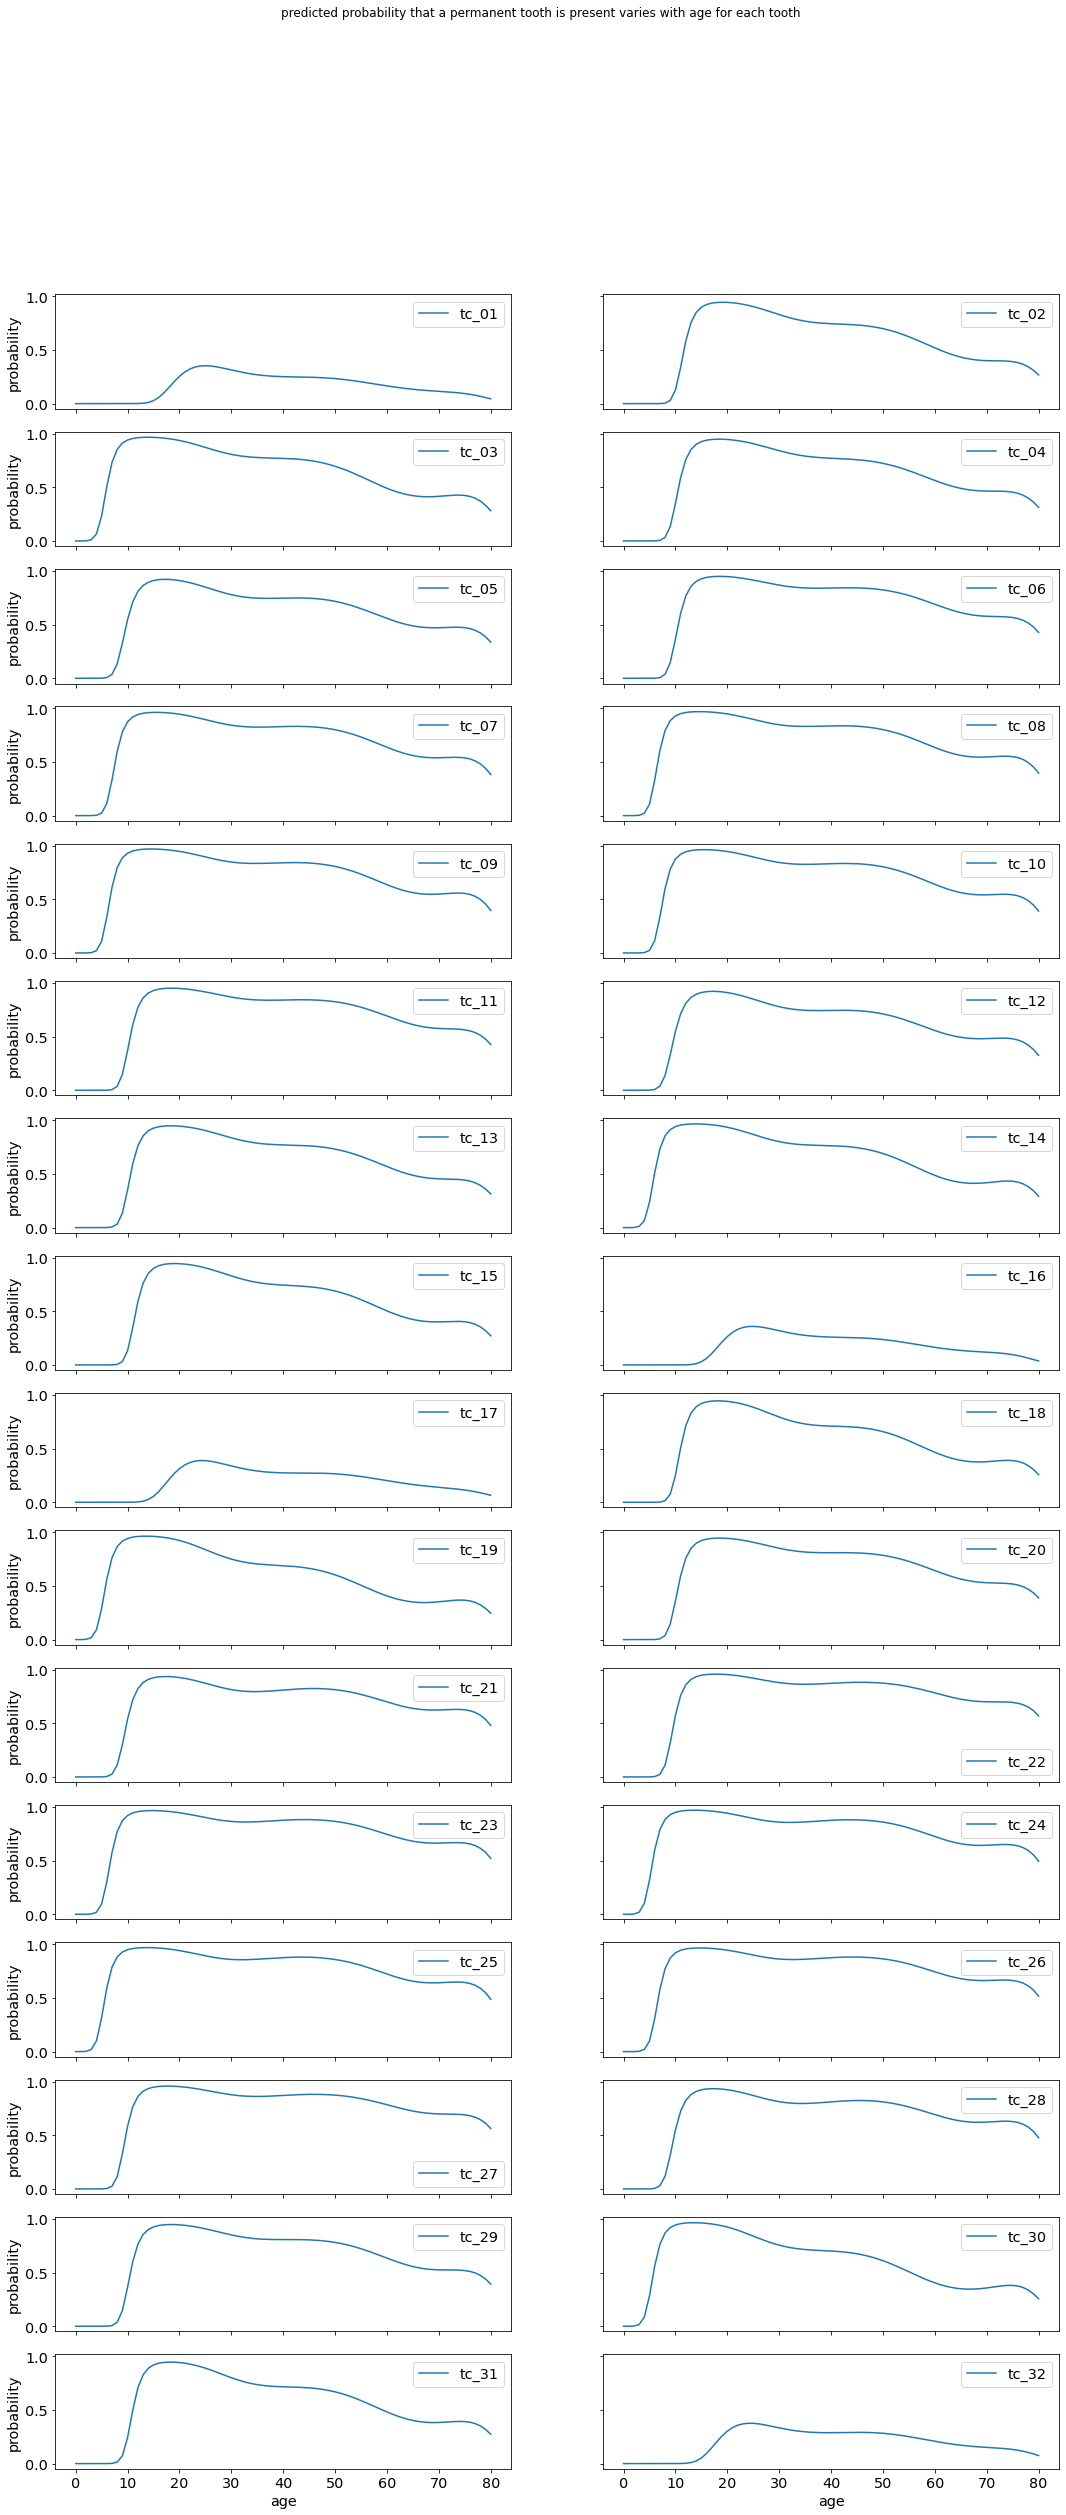

In [11]:
# sort the dataframe
tc_data.sort_values(by=['age'],inplace=True)

fig, axes = plt.subplots(len(tc_cols)//2,2,figsize=(18,40),sharex=True,sharey=True)
fig.suptitle('predicted probability that a permanent tooth is present varies with age for each tooth')

axes = axes.ravel()
for ind, tc in enumerate(tc_cols):
    tc_data.plot(x='age',y=tc,ax=axes[ind])

    axes[ind].set_xlabel('age')
    axes[ind].set_ylabel('probability')

plt.show()

## Question 2 - Hosmer-Lemeshow Calibration Plot

1. Split the data into deciles based on the fitted (aka predicted) probabilities your model assigns to each subject’s tooth. The 10 groups you create using deciles should be approximately equal in size.

2. Within each decile, compute the observed proportion of cases with a permanent tooth present and the expected proportion found by averaging the probabilities.

3. Create a scatter plot comparing the observed and expected probabilities within each decile and add a line through the origin with slope 1 as a guide. Your model is considered well-calibrated if the points in this plot fall approximately on this line.

4. Briefly comment on how-well calibrated your model is (or is not).

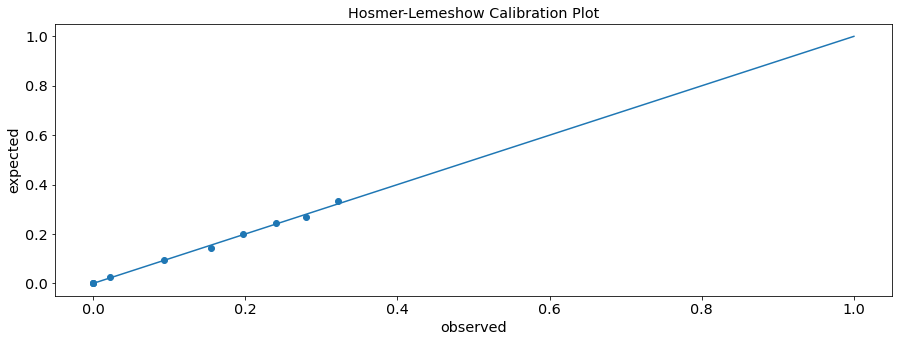

In [12]:
# model fit for tc_01
mod = smf.logit(fbest, data=tc01_f_data)
res = mod.fit(disp=False)
tc01_f_data['probability'] = mod.predict(res.params)

# sort this dataframe
tc01_f_data.sort_values(by='probability',inplace=True)

n_grps = 10
size_grp = (tc01_f_data.shape[0])//n_grps

observed = np.zeros(n_grps)
expected = np.zeros(n_grps)

# compute the observed and expected proportion
for i in range(n_grps):
    g_data = tc01_f_data.iloc[i*size_grp:(i+1)*size_grp]
    observed[i] = g_data['permanent_tooth_present'].mean()
    expected[i] = g_data['probability'].mean()

fig, ax = plt.subplots()
ax.scatter(observed,expected)
ax.plot([0,1],[0,1])
ax.set_xlabel('observed')
ax.set_ylabel('expected')
ax.set_title('Hosmer-Lemeshow Calibration Plot')
plt.show()

As can be seen from the figure, the results pass the Hosmer-Lemeshow goodness-of-fit test. All points in this plot fall approximately on this line. So our model is reliable.